# Object tracking

In [38]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from filterjax import KalmanFilter, plot_posterior_covariance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## One dimension

This simulated problem is taken from Kalman and Bayesian filters in Python by Roger Labbe. The problem is to track a dog in a hallway. The dog is wearing an RFID tag and there is a sensor at the left end of the hallway. The sensor returns the distance of the dog from the left end of the hallway in meters. So, 23.4 would mean the dog is 23.4 meters from the left end of the hallway.

In [39]:
class DogSensor:

    def __init__(self, key, x0=0, velocity=1, noise=0.0):
        self.key = key
        self.x = jnp.array(x0)
        self.velocity = jnp.array(velocity)
        self.noise = jnp.sqrt(noise)

    def sense(self, shape: tuple = (1,)):
        x = []
        for _ in range(shape[0]):
            self.x += self.velocity
            x.append(self.x)
    
        return jnp.array(x) + jax.random.normal(self.key, shape) * self.noise

In [40]:
movement = 1
movement_error = 2
sensor_error = 10
pos = (0, 500)

key = jax.random.PRNGKey(0)
dog = DogSensor(key, x0=pos[0], velocity=movement, noise=sensor_error)
emissions = dog.sense((50,))

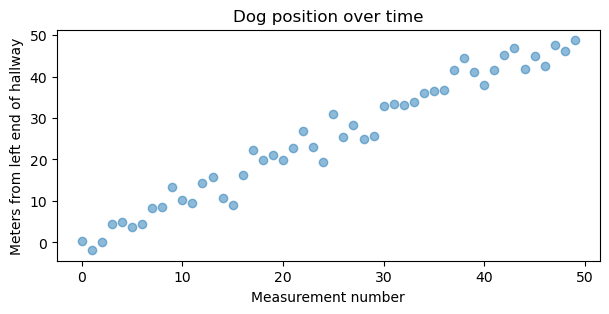

In [41]:
plt.figure(figsize=(7, 3))
plt.scatter(jnp.arange(50), emissions, alpha=0.5)
plt.ylabel("Meters from left end of hallway")
plt.xlabel("Measurement number")
plt.title("Dog position over time");

In [42]:
def Q_DWPA(dim, dt=1., sigma=1.):
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = jnp.array([[.25*dt**4, .5*dt**3],
                    [ .5*dt**3,    dt**2]], dtype=float)
    else:
        Q = jnp.array([[.25*dt**4, .5*dt**3, .5*dt**2],
                    [ .5*dt**3,    dt**2,       dt],
                    [ .5*dt**2,       dt,        1]], dtype=float)
    return Q * sigma

In [43]:
F = jnp.array([[1, 1], [0, 1]])
H = jnp.array([[1, 0]])
Q = Q_DWPA(2, sigma=0.)
R = jnp.eye(1) * 5
P = jnp.eye(2) * 500.
m = jnp.array([0., 0.])

In [44]:
kf = KalmanFilter(state_dim=2, emission_dim=1)
params = kf.initialize(m, F, H, R, Q, P)
posterior = kf.filter(params, emissions)

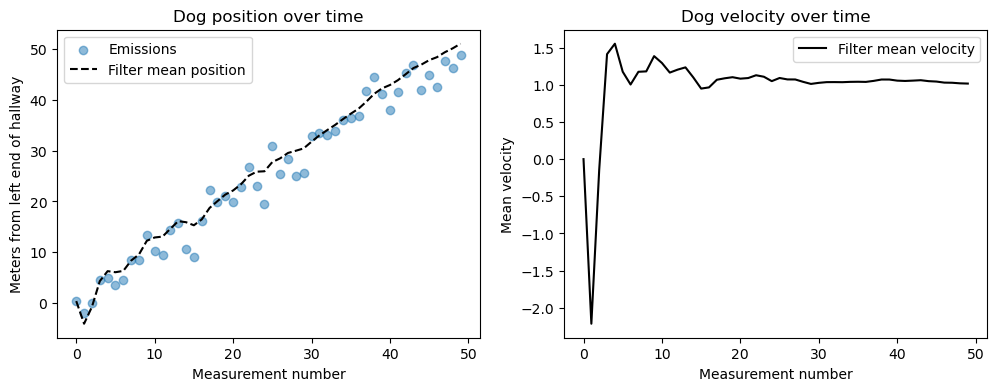

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(jnp.arange(50), emissions, alpha=0.5, label="Emissions")
ax[0].plot(jnp.arange(50), posterior.mean[:, 0], linestyle="--", color="black", label="Filter mean position")
ax[0].set_ylabel("Meters from left end of hallway")
ax[0].set_xlabel("Measurement number")
ax[0].set_title("Dog position over time")
ax[0].legend()

ax[1].plot(jnp.arange(50), posterior.mean[:, 1], color="black", label="Filter mean velocity")
ax[1].set_ylabel("Mean velocity")
ax[1].set_xlabel("Measurement number")
ax[1].set_title("Dog velocity over time")
ax[1].legend();

## Two dimensions

In [56]:
class PositionSensor:

    def __init__(self, pos=[0, 0], vel=(0, 0), noise=1.):
        self.pos = pos
        self.vel = vel
        self.noise = noise
    
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]

        return [self.pos[0] + np.random.randn() * self.noise,
                self.pos[1] + np.random.randn() * self.noise]

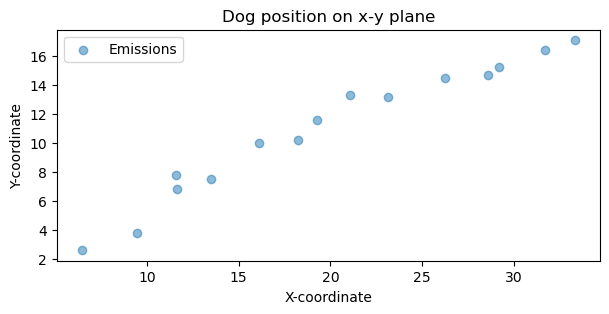

In [57]:
ps = PositionSensor([4, 3], (2, 1), 1)
emissions = jnp.array([ps.read() for _ in range(15)])

plt.figure(figsize=(7, 3))
plt.scatter(emissions[:, 0], emissions[:, 1], alpha=0.5, label="Emissions")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Dog position on x-y plane")
plt.legend();

## Design the Kalman Filter

### Step 1. Choose the state variables

Since we are tracking in two dimensions and have a sensor that returns a measurement in each of the two coordindates ($x-y$ plane), we have two _observed_ variables $x$ and $y$. However, we now have two _unobserved_ variables where the unobserved variables are the velocity of the $x$ and $y$ states. 

In [58]:
m = jnp.array([0, 0, 0, 0], dtype=jnp.float32)
m

Array([0., 0., 0., 0.], dtype=float32)

### Step 2. Design the state transition matrix

The state transition matrix is the matrix that we multiply with the previous state of the system to get the next state.

In [59]:
# assume measurement every seoncd
dt = 1.
F = jnp.array([
    [1., dt, 0, 0],
    [0, 1., 0, 0],
    [0, 0, 1., dt],
    [0, 0, 0, 1.]
])
F

Array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### Step 3: Design the motion function

There are no control inputs, so we can set this term to zero. Default is zero.

### Step 4: Design the measurement function

The measurement function $\mathbf{H}$ defines how we go from the state variables to the measurements. This function is needed because with the Kalman Filter, we go from measurements to state variables. However, the update step needs to compute the residual between the current measurement and the measurement represented by the prediction step. Therefore, $\mathbf{H}$ is multiplied by the state $x$ to produce a measurement $z$

$$z = \mathbf{H}x$$

Since the state and measurement are both positions, $(x, y)$, we don't need to do any converting here.

In [60]:
H = jnp.array([
    [1., 0, 0, 0],
    [0, 0, 1., 0]
])
H

Array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

### Step 5: Design the measurement noise matrix

The measurement noise matrix models the noise in the sensor's measurements.

In [61]:
R = jnp.array([
    [5, 0],
    [0, 5]
])
R

Array([[5, 0],
       [0, 5]], dtype=int32)

### Step 6: Design the process noise matrix

The process noise matrix models the process (). This is the noise that is added to the state variables at each time step.

In [62]:
Q = jnp.eye(4) * 0.1
Q

Array([[0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. ],
       [0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0.1]], dtype=float32)

### Step 7: Set initial conditions

In [63]:
P = jnp.eye(4) * 100
P

Array([[100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.]], dtype=float32)

## Kalman filter implementation

In [ ]:
kf = KalmanFilter(state_dim=4., emission_dim=2.)
params = kf.initialize(m, F, H, R, Q, P)
posterior = kf.filter(params, emissions)

### Plotting filter results

#### Plot posterior state mean and covariance 

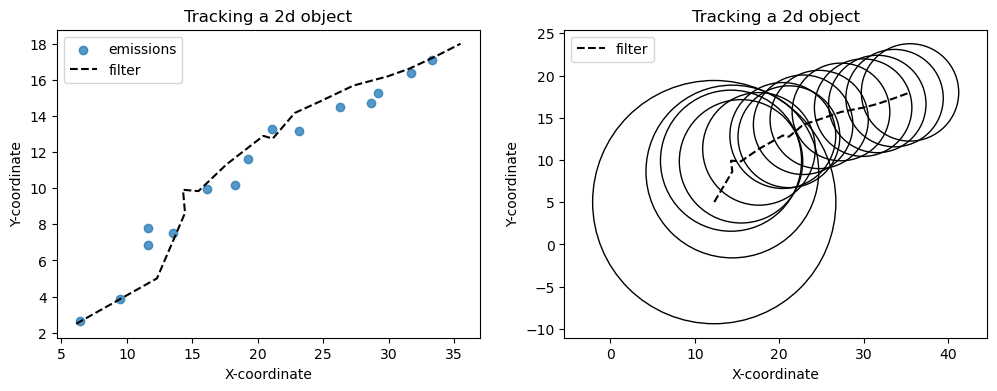

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# posterior.mean --> [x, vx, y, vy]
ax[0].scatter(
    emissions[:, 0], emissions[:, 1],
    alpha=0.75, label="emissions"
)
ax[0].plot(
    posterior.mean[:, 0], posterior.mean[:, 2],
    linestyle="--", color="black",
    label="filter"
)
ax[0].set_xlabel("X-coordinate")
ax[0].set_ylabel("Y-coordinate")
ax[0].set_title("Tracking a 2d object")
ax[0].legend()

# posterior.covariance
xy_cov = []
for cov in posterior.covariance:
    xy_cov.append(
        jnp.array(
            [[cov[0, 0], cov[0, 2]], 
            [cov[2, 0], cov[2, 2]]]
            )
        )
xy_cov = jnp.array(xy_cov)

ax[1].plot(
    posterior.mean[1:, 0], posterior.mean[1:, 2],
    linestyle="--", color="black",
    label="filter"
)
ax[1] = plot_posterior_covariance(
    posterior.mean[1:, [0, 2]],
    xy_cov[1:],
    ax=ax[1],
    legend_kwargs={"legend": "covariance"}
)
ax[1].set_xlabel("X-coordinate")
ax[1].set_ylabel("Y-coordinate")
ax[1].set_title("Tracking a 2d object");
ax[1].legend();